In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
from anndata import AnnData

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

import hdf5plugin

In [2]:
path = "../data/brca/tcga/processed/GSE161529/genes_prop_subtypes_cells_normal.csv"
adata = pd.read_csv(path, sep=",").T
adata = adata.iloc[0:3,:]

In [3]:
adata.head(5)

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,RP11-744A16.4,PAUPAR,RP11-65B7.2,GIMAP1-GIMAP5,RP11-274B21.13,AF127936.7,CH17-132F21.5,RP11-439M15.1,LINC01144,RP11-418H16.1
I3 T cell,306908.403883,52912.365936,115666.913110,85601.649366,20469.777124,49877.022988,516312.356479,130917.288751,176015.091877,145164.930126,...,6.414516,14.431680,109.260955,0.0,14.329764,738.261116,58.694433,46.033138,5863.076237,273.638524
I5 Plasma cell,3204.195471,264.298255,1158.055176,863.881266,164.010084,265.475651,2038.154760,1220.531531,1232.351483,1345.560826,...,0.066488,0.134212,0.417081,0.0,0.171273,3.835534,0.597043,0.212605,85.097735,3.941455
I1 Myeloid cell,202554.440966,38804.895736,78938.734639,55365.299069,13545.568544,32673.200360,374858.227258,89040.819359,133488.347442,93854.275880,...,5.402443,8.932429,71.525943,0.0,8.271746,519.739157,48.096404,27.707610,3590.986753,174.215185


In [4]:
# Transform to AnnData object
adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 3 × 54645

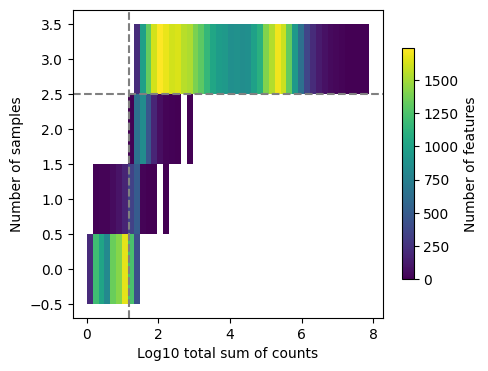

In [5]:
dc.plot_filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)


In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group=None, min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 3 × 36230

In [7]:
model = dc.get_progeny(organism='human', top=300)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
4195,p53,F5,2.397854,5.746843e-08
4196,p53,MKI67,-5.680340,5.758565e-08
4197,p53,THOC2,-2.108178,5.858359e-08
4198,p53,POLA1,-4.943873,5.911873e-08


In [8]:
pd.unique(model.source)

array(['Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK',
       'NFkB', 'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype=object)

In [9]:
adata.X

array([[3.06908406e+05, 5.29123672e+04, 1.15666914e+05, ...,
        4.60331383e+01, 5.86307617e+03, 2.73638519e+02],
       [3.20419556e+03, 2.64298248e+02, 1.15805518e+03, ...,
        2.12604612e-01, 8.50977325e+01, 3.94145489e+00],
       [2.02554438e+05, 3.88048945e+04, 7.89387344e+04, ...,
        2.77076111e+01, 3.59098682e+03, 1.74215179e+02]], dtype=float32)

In [10]:
# Infer pathway activities with consensus
dc.run_consensus(mat=adata, 
                 net=model,
                 use_raw=False, 
                 verbose=True)

Running consensus.
Running mlm on mat with 3 samples and 36230 targets for 14 sources.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.98it/s]


Running ulm on mat with 3 samples and 36230 targets for 14 sources.
Running wsum on mat with 3 samples and 36230 targets for 14 sources.
Infering activities on 1 batches.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [11]:
adata

AnnData object with n_obs × n_vars = 3 × 36230
    obsm: 'consensus_estimate', 'consensus_pvals'

In [12]:
# Extract from dictionary
acts =  adata.obsm['consensus_estimate']
pvals = adata.obsm['consensus_pvals']

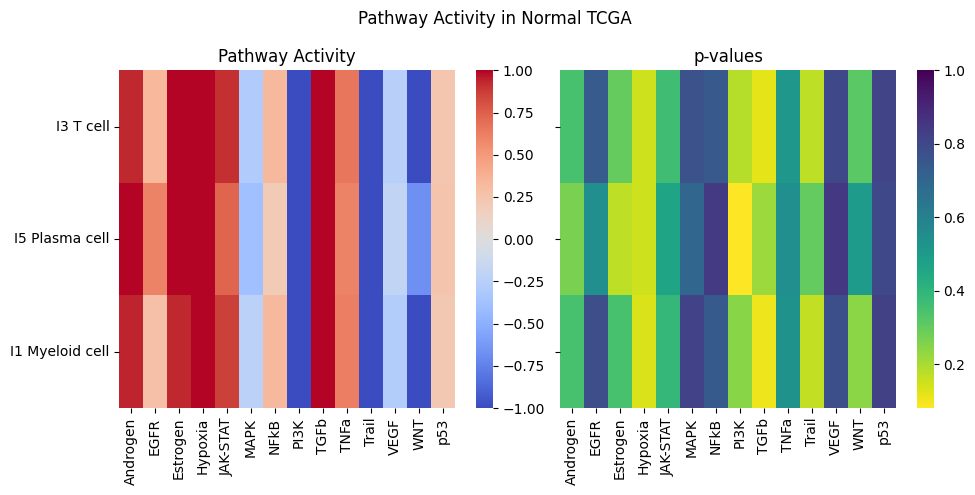

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5), tight_layout=True, sharey=True)

axes[0].set_title('Pathway Activity')
g = sns.heatmap(acts, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 10)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 10)
axes[1].set_title('p-values')
sns.heatmap(pvals, cmap='viridis_r', ax=axes[1], vmax=1)
path = "../figures/GSE161529/Immune_normal_subtype_cell_cancer_pathways.png"
fig.suptitle("Pathway Activity in Normal TCGA")
plt.savefig(path,format='png')
plt.show()
plt.close()